In [1]:
import sklearn
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import clone
from numpy import mean
from numpy import std

In [2]:
# ML Algorithms used 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import StackingClassifier

In [3]:
from func import *

In [4]:
# Example tsv files
datasets = {
            'cnv': 'data/breast/CNV_processedDat.txt',
            'mrna': 'data/breast/mRNA_processedDat.txt',
            'prot': 'data/breast/PROT_processedDat.txt'
}
        
labels = 'data/breast/TCGA_BRCA_subtypes.txt'

Loading the data:

In [5]:
data = {}
target = {}

train_data = {}
train_target = {}

eval_data = {}
eval_target = {}

for modality in datasets:
    data[modality], target[modality] = load_data(datasets[modality], labels)
    train_data[modality], eval_data[modality], train_target[modality], eval_target[modality] = train_test_split(data[modality], target[modality], test_size=0.2, train_size=0.8)


Setting up the pipelines:

In [6]:
pipe_list = {}

# Setting up the pipes
for modality in datasets:
    pipes = {}

    for model in estimators:
        pipe=Pipeline(steps=[('data_prep',transformer),model])
        pipes[pipe.steps[1][0]]=pipe

    pipe_list[modality] = pipes

# Individual Model Scores

In [9]:
col_names = ['model', 'accuracy']
cross_val_list = {}

for modality in datasets:
    
    cross_val = pd.DataFrame(columns=col_names)

    for name, pipe in pipe_list[modality].items():

        scores = cross_val_score(pipe, data[modality], target[modality], cv=5)
        
        cross_val = pd.concat([cross_val, pd.DataFrame([[name, "%0.3f +/- %0.3f" % (scores.mean(), scores.std())]], columns=col_names)], ignore_index=True)

    cross_val_list[modality] = cross_val

In [12]:
display(cross_val_list['cnv']), display(cross_val_list['mrna']), display(cross_val_list['prot'])

,model,accuracy
0,logistic,0.611 +/- 0.038
1,lasso,0.655 +/- 0.054
2,elasticnet,0.581 +/- 0.035
3,random_forest,0.675 +/- 0.036
4,deep_nn,0.613 +/- 0.033


,model,accuracy
0,logistic,0.793 +/- 0.024
1,lasso,0.857 +/- 0.022
2,elasticnet,0.797 +/- 0.025
3,random_forest,0.845 +/- 0.024
4,deep_nn,0.817 +/- 0.036


,model,accuracy
0,logistic,0.619 +/- 0.182
1,lasso,0.678 +/- 0.101
2,elasticnet,0.629 +/- 0.188
3,random_forest,0.582 +/- 0.053
4,deep_nn,0.621 +/- 0.034


(None, None, None)

# Individual Scores with Reduced Dimensionality

TO DO: Implement PCA

# Voting Ensemble

In [13]:
def voting_ensemble(estimators, esm_metrics, voting, data, target):
    cv = KFold(n_splits=5, random_state=None, shuffle=True)
    scores = list()

    for train_index, test_index in cv.split(data):
        
        # Spliting into intermediate training and test sets
        x_tr_va, x_test = data.iloc[train_index, :], data.iloc[test_index, :]
        y_tr_va, y_test = target.iloc[train_index], target.iloc[test_index]

        # Spliting training set into training and validation set
        x_train, x_val, y_train, y_val = train_test_split(x_tr_va, y_tr_va, test_size=0.25, random_state=1)

        print('Training base estimators...')
        # Training individual base estimators
        pipes = train_models(estimators, x_train, y_train, transformer)

        # Getting predictions from individual base estimators
        pred, pred_proba = prediction_results(pipes, x_val)

        print('Finding optimal weights...')

        # Finding optimal weights given predictions
        weights = find_weights(estimators, pipes, y_val, pred_proba)

        # Setting up ensemble voting classifier using calculated weights
        ens = Pipeline(steps=[('data_prep',transformer),(modality,VotingClassifier(estimators=estimators, voting = voting, weights = weights))])

        ens.fit(x_train, y_train)

        accuracy_score = ens.score(x_test, y_test)
        
        scores.append(accuracy_score)

        print('Training/Test Split Distribution: %s, Accuracy: %.3f' % (np.bincount(y_train), accuracy_score))
    
    print('\n\nCross-Validation accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))    

    # Creating metrics dataframe
    esm_metrics = pd.concat([esm_metrics, pd.DataFrame([[modality, '%.3f +/- %.3f' %(np.mean(scores), np.std(scores))]], columns=col_names)], ignore_index=True)

    return esm_metrics

In [16]:
ensemble_estimators = {}
esm_metrics = pd.DataFrame(columns=col_names)

for modality in datasets:
    ensemble_estimators=[(pipe.steps[1][0],clone(pipe.steps[1][1])) for pipe in pipe_list[modality].values()]
    esm_metrics = voting_ensemble(ensemble_estimators, esm_metrics, 'soft', data[modality], target[modality])


Training base estimators...
Finding optimal weights...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Training/Test Split Distribution: [ 56  38 138  68], Accuracy: 0.723
Training base estimators...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Finding optimal weights...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Training/Test Split Distribution: [ 57  35 129  79], Accuracy: 0.630
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [ 53  33 140  74], Accuracy: 0.640
Training base estimators...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Finding optimal weights...
Training/Test Split Distribution: [ 63  28 145  64], Accuracy: 0.690
Training base estimators...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Finding optimal weights...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Training/Test Split Distribution: [ 56  28 147  69], Accuracy: 0.550


Cross-Validation accuracy: 0.647 +/- 0.059
Training base estimators...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Finding optimal weights...
Training/Test Split Distribution: [ 58  38 131  71], Accuracy: 0.860
Training base estimators...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Finding optimal weights...
Training/Test Split Distribution: [ 54  32 133  79], Accuracy: 0.840
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [ 55  36 139  68], Accuracy: 0.800
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [ 60  32 138  69], Accuracy: 0.859
Training base estimators...
Finding optimal weights...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Training/Test Split Distribution: [ 59  32 140  68], Accuracy: 0.828


Cross-Validation accuracy: 0.837 +/- 0.022
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [14 11 17 19], Accuracy: 0.619
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [14 13 15 19], Accuracy: 0.762
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [15  9 17 20], Accuracy: 0.619
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [15 10 19 18], Accuracy: 0.650
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [19  8 21 14], Accuracy: 0.250


Cross-Validation accuracy: 0.580 +/- 0.173


In [17]:
esm_metrics

,model,accuracy
0,cnv,0.647 +/- 0.059
1,mrna,0.837 +/- 0.022
2,prot,0.580 +/- 0.173


# Boosting Ensemble

XGBoost

In [7]:
def trainModel(model, x_train, y_train, n_folds):
    cv = KFold(n_splits= n_folds)
    scores = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    y_pred = cross_val_predict(model, x_train, y_train, cv=cv, method='predict') 
    return scores, y_pred

In [8]:
def trainBoostModel(x_train, y_train, n_folds):
    cv = KFold(n_splits= n_folds)
    gbm = xgb.XGBClassifier().fit(x_train, y_train)
    
    scores = cross_val_score(gbm, x_train, y_train, scoring='accuracy', cv=cv)
    return scores

In [9]:
cross_val_list = {}
col_names = ['model', 'accuracy']
modality_scores = pd.DataFrame(columns=col_names)

for modality in datasets:
    
    cross_val = pd.DataFrame(columns=col_names)
    predictions = {}

    for name, pipe in pipe_list[modality].items():

        scores, predictions[name] = trainModel(pipe, data[modality], target[modality], 5)
        cross_val = pd.concat([cross_val, pd.DataFrame([[name, "%0.3f +/- %0.3f" % (scores.mean(), scores.std())]], columns=col_names)], ignore_index=True)

    stacked_train = np.column_stack(list(predictions.values()))
    stackModel_scores = trainBoostModel(stacked_train, target[modality], 5)
    modality_scores = pd.concat([modality_scores, pd.DataFrame([[modality, "%0.3f +/- %0.3f" % (stackModel_scores.mean(), stackModel_scores.std())]], columns=col_names)], ignore_index=True)

    cross_val_list[modality] = cross_val

In [10]:
display(cross_val_list['cnv'], cross_val_list['mrna'], cross_val_list['prot'])

,model,accuracy
0,logistic,0.613 +/- 0.047
1,lasso,0.651 +/- 0.053
2,elasticnet,0.581 +/- 0.049
3,random_forest,0.673 +/- 0.062
4,deep_nn,0.585 +/- 0.075


,model,accuracy
0,logistic,0.795 +/- 0.022
1,lasso,0.847 +/- 0.033
2,elasticnet,0.813 +/- 0.045
3,random_forest,0.831 +/- 0.062
4,deep_nn,0.815 +/- 0.018


,model,accuracy
0,logistic,0.669 +/- 0.111
1,lasso,0.717 +/- 0.109
2,elasticnet,0.687 +/- 0.130
3,random_forest,0.620 +/- 0.080
4,deep_nn,0.572 +/- 0.131


In [11]:
modality_scores

,model,accuracy
0,cnv,0.647 +/- 0.061
1,mrna,0.813 +/- 0.048
2,prot,0.572 +/- 0.132


In [ ]:
modality_scores

AdaBoost Classifier (Implement this)

In [22]:
from sklearn.ensemble import AdaBoostClassifier

ADBclf = AdaBoostClassifier(n_estimators = 100, random_state = 0)
scores = ADBclf.fit(data['mrna'], target['mrna'])

In [23]:
ADBclf.score(data['mrna'], target['mrna'])

0.6967871485943775

# Stacking Ensemble

Logistic Regression as Meta Estimator:

In [14]:
# get a stacking ensemble of models
def trainStackingModel(pipes, final_estimator, data, target, cv):

    # Create the transformer to impute missing values
    imputer = SimpleImputer(strategy='mean')

    level1 = Pipeline(steps=[('prep', imputer), ('lr', final_estimator)])
    
    # define the stacking ensemble
    model = Pipeline(steps=[('data_prep',transformer),('stacking',StackingClassifier(estimators=pipes, final_estimator=level1, cv=cv))])

    # calculating scores
    cv = KFold(n_splits=cv)
    scores = cross_val_score(model, data, target, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

    return model, scores

In [8]:
col_names = ['model', 'accuracy']
stacking_metrics = pd.DataFrame(columns=col_names)
stacking_model = {}

for modality in datasets:
    print("dataset: " + modality)
    stacking_model[modality], scores = trainStackingModel(estimators, LogisticRegression(), data[modality], target[modality], 3)

    stacking_metrics = pd.concat([stacking_metrics, pd.DataFrame([[modality, '%.3f +/- %.3f' %(np.mean(scores), np.std(scores))]], columns=col_names)], ignore_index=True)

dataset: cnv


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= p

dataset: mrna
dataset: prot


In [9]:
stacking_metrics

,model,accuracy
0,cnv,0.683 +/- 0.072
1,mrna,0.857 +/- 0.028
2,prot,0.574 +/- 0.149


# Sequential Feature Selection

In [35]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

In [51]:
def sequential_forward_selection(estimator, X, y, k_features, forward, floating=False, scoring='accuracy', cv=3, n_jobs=-1):
    # Sequential Forward Selection
      sfs = SFS(estimator, 
          k_features=k_features, 
          forward=forward, 
          floating=floating, 
          scoring=scoring,
          cv=cv,
          n_jobs=n_jobs)
    
      sfs = sfs.fit(X, y)
    
      return sfs

## mRNA

In [40]:
data['mrna'].shape

(498, 17939)

In [39]:
knn = KNeighborsClassifier(n_neighbors=3)

In [52]:
sfs = sequential_forward_selection(knn, data['mrna'], target['mrna'], k_features = (10, 30), forward=True)

In [53]:
print('\nSequential Forward Selection, mRNA (k=20):')

pd.DataFrame.from_dict(sfs.get_metric_dict()).T


Sequential Forward Selection, mRNA (k=20):


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(1362,)","[0.6265060240963856, 0.6144578313253012, 0.554...",0.598394,"(FOXM1,)",0.071161,0.031623,0.02236
2,"(1362, 7393)","[0.7530120481927711, 0.7349397590361446, 0.746...",0.74498,"(FOXM1, SLC39A6)",0.016908,0.007513,0.005313
3,"(1355, 1362, 7393)","[0.8192771084337349, 0.8012048192771084, 0.783...",0.801205,"(FOXC1, FOXM1, SLC39A6)",0.033206,0.014756,0.010434
4,"(1355, 1362, 2549, 7393)","[0.8192771084337349, 0.8493975903614458, 0.825...",0.831325,"(FOXC1, FOXM1, MYO10, SLC39A6)",0.029285,0.013014,0.009202
5,"(1355, 1362, 2549, 4177, 7393)","[0.8433734939759037, 0.8493975903614458, 0.843...",0.845382,"(FOXC1, FOXM1, MYO10, HIRA, SLC39A6)",0.00639,0.00284,0.002008
6,"(1355, 1362, 2549, 4177, 5652, 7393)","[0.8433734939759037, 0.8554216867469879, 0.849...",0.849398,"(FOXC1, FOXM1, MYO10, HIRA, ZC3H11A, SLC39A6)",0.011069,0.004919,0.003478
7,"(1355, 1362, 2549, 4177, 4208, 5652, 7393)","[0.8313253012048193, 0.8614457831325302, 0.867...",0.853414,"(FOXC1, FOXM1, MYO10, HIRA, UBE2L3, ZC3H11A, S...",0.035581,0.015811,0.01118
8,"(1355, 1362, 2549, 4161, 4177, 4208, 5652, 7393)","[0.8433734939759037, 0.8674698795180723, 0.867...",0.859438,"(FOXC1, FOXM1, MYO10, TTC1, HIRA, UBE2L3, ZC3H...",0.025562,0.011359,0.008032
9,"(1355, 1362, 2549, 3360, 4161, 4177, 4208, 565...","[0.8493975903614458, 0.8614457831325302, 0.867...",0.859438,"(FOXC1, FOXM1, MYO10, RBBP5, TTC1, HIRA, UBE2L...",0.016908,0.007513,0.005313
10,"(1160, 1355, 1362, 2549, 3360, 4161, 4177, 420...","[0.8433734939759037, 0.8674698795180723, 0.873...",0.861446,"(ELAVL1, FOXC1, FOXM1, MYO10, RBBP5, TTC1, HIR...",0.029285,0.013014,0.009202


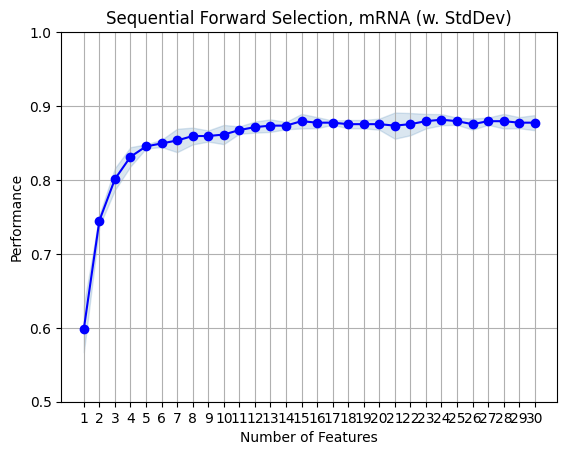

In [54]:
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.ylim([0.5, 1])
plt.title('Sequential Forward Selection, mRNA (w. StdDev)')
plt.grid()
plt.show()

In [63]:
print('top cv score: ' + str(sfs.k_score_))
print('feature indexes: ' + str(sfs.k_feature_idx_))
print('feature names: ' + str(sfs.k_feature_names_))

top cv score: 0.8815261044176707
feature indexes: (530, 1160, 1355, 1362, 2549, 2573, 2962, 3360, 3551, 4161, 4177, 4208, 4326, 4397, 4573, 4699, 5652, 6275, 7180, 7393, 7594, 8459, 9529, 11315)
feature names: ('KRIT1', 'ELAVL1', 'FOXC1', 'FOXM1', 'MYO10', 'NCK1', 'PKM', 'RBBP5', 'SAFB', 'TTC1', 'HIRA', 'UBE2L3', 'SF1', 'ZNF143', 'RBM10', 'RANBP3', 'ZC3H11A', 'EBP', 'TARDBP', 'SLC39A6', 'SZRD1', 'DBR1', 'PARL', 'ADCK4')


## Prot

In [45]:
data['prot'].shape

TCGA-A2-A0D0    0
TCGA-BH-A0HK    2
TCGA-C8-A12T    1
TCGA-A2-A0D2    0
TCGA-C8-A12U    3
               ..
TCGA-BH-A18Q    0
TCGA-C8-A130    1
TCGA-E2-A159    0
TCGA-A2-A0T3    3
TCGA-A2-A0YD    2
Name: PAM50, Length: 103, dtype: category
Categories (4, int64): [0, 1, 2, 3]

In [36]:
knn = KNeighborsClassifier(n_neighbors=3)

In [15]:
'''# Create the transformer to impute missing values
imputer = SimpleImputer(strategy='mean')

level1 = Pipeline(steps=[('prep', imputer), ('lr', LogisticRegression())])
    
# define the stacking ensemble
model = Pipeline(steps=[('data_prep',transformer),('stacking',StackingClassifier(estimators=estimators, final_estimator=level1, cv=3))])
'''
# Sequential Forward Selection
sfs = SFS(knn, 
          k_features=20, 
          forward=True, 
          floating=False, 
          scoring='accuracy',
          cv=3,
          n_jobs=-1)

sfs = sfs.fit(data['prot'], target['prot'])

In [ ]:
# Sequential Backward Selection
sbs = SFS(knn, 
          k_features=3, 
          forward=False, 
          floating=False, 
          scoring='accuracy',
          cv=3,
          n_jobs=-1)
sbs = sbs.fit(data['prot'], target['prot'])

In [38]:
print('\nSequential Forward Selection (k=20):')

pd.DataFrame.from_dict(sfs.get_metric_dict()).T


Sequential Forward Selection (k=20):


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(4725,)","[0.5714285714285714, 0.4411764705882353, 0.5]",0.504202,"(NUDT4,)",0.119848,0.053258,0.037659
2,"(4725, 7612)","[0.6285714285714286, 0.5882352941176471, 0.588...",0.601681,"(NUDT4, UGP2)",0.042789,0.019015,0.013445
3,"(4725, 6326, 7612)","[0.6, 0.7058823529411765, 0.6764705882352942]",0.660784,"(NUDT4, SERPINB1, UGP2)",0.100425,0.044627,0.031556
4,"(4725, 6326, 6346, 7612)","[0.6285714285714286, 0.6764705882352942, 0.764...",0.689916,"(NUDT4, SERPINB1, SETD3, UGP2)",0.126883,0.056384,0.039869
5,"(2060, 4725, 6326, 6346, 7612)","[0.6571428571428571, 0.7058823529411765, 0.705...",0.689636,"(EDC4, NUDT4, SERPINB1, SETD3, UGP2)",0.051704,0.022976,0.016246
6,"(2060, 4443, 4725, 6326, 6346, 7612)","[0.6857142857142857, 0.7058823529411765, 0.735...",0.708964,"(EDC4, NCKAP1, NUDT4, SERPINB1, SETD3, UGP2)",0.045812,0.020358,0.014395
7,"(2060, 4443, 4725, 5514, 6326, 6346, 7612)","[0.7428571428571429, 0.7352941176470589, 0.705...",0.728011,"(EDC4, NCKAP1, NUDT4, PSMC2, SERPINB1, SETD3, ...",0.035891,0.015949,0.011278
8,"(2060, 4443, 4532, 4725, 5514, 6326, 6346, 7612)","[0.7142857142857143, 0.6764705882352942, 0.764...",0.718487,"(EDC4, NCKAP1, NELFE, NUDT4, PSMC2, SERPINB1, ...",0.081336,0.036144,0.025558
9,"(2060, 4443, 4532, 4725, 5514, 6045, 6326, 634...","[0.7142857142857143, 0.7352941176470589, 0.764...",0.738095,"(EDC4, NCKAP1, NELFE, NUDT4, PSMC2, RPRD1B, SE...",0.046535,0.020679,0.014622
10,"(2060, 2119, 4443, 4532, 4725, 5514, 6045, 632...","[0.7428571428571429, 0.7352941176470589, 0.794...",0.757423,"(EDC4, EIF3B, NCKAP1, NELFE, NUDT4, PSMC2, RPR...",0.058801,0.02613,0.018477


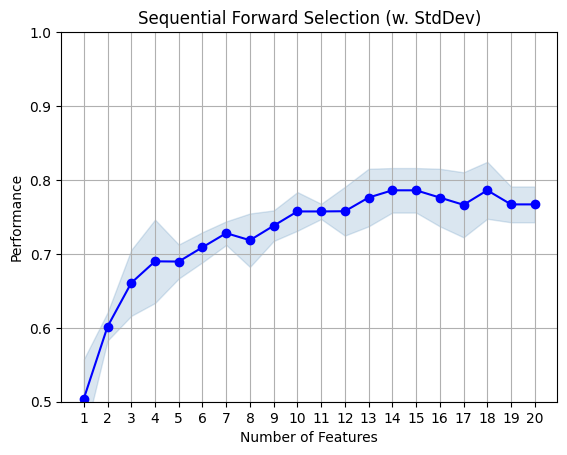

In [34]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.ylim([0.5, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

From this, we can see that the performance starts to plateau at around 10 features, with peak performance with 14/15 features.

## Running ensemble with selected features:

In [ ]:
# first, create a custom column selector to select specific columns 
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnSelector(BaseEstimator, TransformerMixin):
    '''select specific columns of a given dataset'''
    def __init__(self, subset):
        self.subset = subset
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.loc[:, self.subset]

In [11]:
from mlxtend.feature_selection import ColumnSelector
data_reduced = {}

mycols = ['BRE', 'EDC4', 'EIF3B', 'EIF3H', 'EXOC4', 'FAM129B', 'NARFL', 'NCKAP1', 'NELFE', 'NMD3', 'NUDT4', 'PIK3C3', 'PSMC2', 'PSMD2', 'RPRD1B', 'SERPINB1', 'SETD3', 'STAMBP', 'TCERG1', 'UGP2']
pipe = ColumnSelector(mycols)

data_reduced['prot'] = pipe.transform(data['prot'])

data_reduced['prot'] = data['prot'][mycols]

In [12]:
data_reduced['prot']

,BRE,EDC4,EIF3B,EIF3H,EXOC4,FAM129B,NARFL,NCKAP1,NELFE,NMD3,NUDT4,PIK3C3,PSMC2,PSMD2,RPRD1B,SERPINB1,SETD3,STAMBP,TCERG1,UGP2
TCGA-A2-A0D0,0.650702,0.720970,0.328830,0.309152,-0.267473,0.071794,0.086089,-0.662919,0.214714,0.102557,1.030769,1.028009,0.397604,0.376461,0.222471,0.085620,-0.275098,0.329546,-0.889984,0.194532
TCGA-BH-A0HK,0.486912,-0.091127,0.365177,-0.012280,0.097264,-0.055967,0.234736,-0.423649,0.243717,0.397548,1.070368,0.079895,0.343476,0.174877,0.132384,0.164004,-0.337957,0.822522,-0.400644,0.060433
TCGA-C8-A12T,0.131578,0.217634,0.263402,0.274167,0.019867,-0.143810,0.155346,-0.175120,0.144836,0.066389,0.320320,0.128008,0.152889,-0.006297,-0.171922,-0.312759,0.101200,0.579226,0.055494,-0.149514
TCGA-A2-A0D2,-0.006399,0.342631,0.099310,0.041005,0.017396,-0.099680,-0.235371,0.145720,0.053466,0.284192,-0.283432,0.304282,0.107105,-0.008541,0.127243,-0.286668,-0.267223,-0.257072,0.165092,0.205282
TCGA-C8-A12U,-0.010398,0.273433,-0.067197,-0.042005,-0.091167,-0.124148,0.059780,-0.402829,-0.138511,0.015586,-0.292306,0.110440,0.291375,0.286832,0.269757,-0.008428,0.243309,0.216917,-0.043346,-0.497674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-BH-A18Q,0.249165,0.193046,0.140007,0.129068,-0.114240,-0.120143,0.074037,-0.117406,0.043173,0.285785,-0.343200,0.367207,-0.164136,-0.171534,0.280626,-0.045967,-0.196025,0.105800,0.179394,0.167979
TCGA-C8-A130,0.232111,0.073094,0.170267,0.245146,0.073877,0.504916,0.006549,-0.092047,0.145808,0.178780,0.496382,-0.031479,0.144462,0.106703,0.070610,-0.306835,0.094600,0.051626,0.170733,0.081452
TCGA-E2-A159,0.495440,0.533497,0.063595,0.219487,-0.408314,0.297268,-0.182793,0.088887,0.036395,0.151728,1.054140,0.373339,0.259920,0.508265,-0.223850,0.804759,1.447327,-0.527520,-0.347000,0.730337
TCGA-A2-A0T3,-0.075769,0.307531,-0.069473,-0.094431,0.123532,-0.003450,-0.006622,0.026172,0.265477,0.211564,-0.035145,-0.024557,-0.004116,0.038883,0.062162,-0.211186,-0.035977,0.088941,0.267747,-0.316077


In [20]:
col_names = ['model', 'accuracy']
metrics = pd.DataFrame(columns=col_names)

model, scores = trainStackingModel(estimators, LogisticRegression(), data_reduced['prot'], target['prot'], 5)

metrics = pd.concat([metrics, pd.DataFrame([[modality, '%.3f +/- %.3f' %(np.mean(scores), np.std(scores))]], columns=col_names)], ignore_index=True)

/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

In [21]:
metrics

,model,accuracy
0,prot,0.620 +/- 0.189


# Mega-Ensemble

Note: This is not yet implemented, will figure out best way to combine modalities

In [ ]:

def trainStackModel(x_train, y_train, x_test, n_folds, seed):
    cv = KFold(n_splits= n_folds, random_state=seed)
    gbm = xgb.XGBClassifier(
     n_estimators= 2000,
     max_depth= 4,
     min_child_weight= 2,
     gamma=0.9,                        
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     scale_pos_weight=1).fit(x_train, y_train)
    
    scores = cross_val_score(gbm, x_train, y_train, scoring='accuracy', cv=cv)
    
    return scores

In [ ]:
def mega_ensemble(estimators, esm_metrics, voting, datasets, data, target):
    cv = KFold(n_splits=5, random_state=None, shuffle=True)
    scores = list()
    modality_estimators = list()
    modality_predictions = {}
    
    for train_index, test_index in cv.split(data):
        for modality in datasets:
            print('dataset: ' + modality)
            # Spliting into intermediate training and test sets
            x_tr_va, x_test = data[modality].iloc[train_index, :], data[modality].iloc[test_index, :]
            y_tr_va, y_test = target[modality].iloc[train_index], target[modality].iloc[test_index]

            # Spliting training set into training and validation set
            x_train, x_val, y_train, y_val = train_test_split(x_tr_va, y_tr_va, test_size=0.25, random_state=1)

            print('Training base estimators...')
            # Training individual base estimators
            pipes = train_models(estimators, x_train, y_train, transformer)

            # Getting predictions from individual base estimators
            pred, pred_proba = prediction_results(pipes, x_val)

            # Finding optimal weights given predictions
            weights = find_weights(estimators, pipes, y_val, pred_proba)

            # Setting up ensemble voting classifier using calculated weights
            ens = Pipeline(steps=[('data_prep',transformer),(modality,VotingClassifier(estimators=estimators, voting = voting, weights = weights))])

            ens.fit(x_train, y_train)

            modality_predictions[modality] = ens.predict_proba(x_val)

            accuracy_score = ens.score(x_test, y_test)
            
            scores.append(accuracy_score)
            modality_estimators.append(ens)

            print('Training/Test Split Distribution: %s, Accuracy: %.3f' % (np.bincount(y_train), accuracy_score))

       
        mega_ens.fit(x_train, y_train)

        # Creating metrics dataframe
        modality_metrics = pd.concat([modality_metrics, pd.DataFrame([[modality, '%.3f +/- %.3f' %(np.mean(scores), np.std(scores))]], columns=col_names)], ignore_index=True)

    return esm_metrics